# einfache Datenbank ohne Security

Steps:

1. Vorbereitung: Datenbank anlegen
2. 2 SQL User anlegen
3. Tabelle anlegen + Daten einfügen
4. Berechtigungen setzten

## (1) Vorbereitung: Datenbank anlegen

In [1]:
use master 
go
alter database [TEST_RLS_SQL]
set single_user with rollback immediate
GO
Drop DATABASE if exists [TEST_RLS_SQL]
GO
CREATE DATABASE [TEST_RLS_SQL]
GO
USE [TEST_RLS_SQL]
GO

Commands completed successfully.

Nonqualified transactions are being rolled back. Estimated rollback completion: 0%.

Nonqualified transactions are being rolled back. Estimated rollback completion: 100%.

Commands completed successfully.

Commands completed successfully.

Commands completed successfully.

Total execution time: 00:00:03.959

## (2) SQL User anlegen

In [2]:
-- User 1: Uster mit eingeschränkten Rechten user_RLS_limited
CREATE LOGIN user_RLS_limited   
    WITH PASSWORD = '8fdKJl3$nlNv3049jsKK';  
GO

USE [TEST_RLS_SQL];  
GO

CREATE USER user_RLS_limited FOR LOGIN user_RLS_limited   
    WITH DEFAULT_SCHEMA = dbo; 
GO

: Msg 15025, Level 16, State 1, Line 2
The server principal 'user_RLS_limited' already exists.

Commands completed successfully.

Commands completed successfully.

Total execution time: 00:00:00.055

In [3]:
-- User 2: User mit uneingeschränkten Rechten user_RLS_unlimited
CREATE LOGIN user_RLS_unlimited   
    WITH PASSWORD = '8fdKJl3$oiuioukljlkdj';  
GO

USE [TEST_RLS_SQL];  
GO

CREATE USER user_RLS_unlimited FOR LOGIN user_RLS_unlimited   
    WITH DEFAULT_SCHEMA = dbo; 
GO

: Msg 15025, Level 16, State 1, Line 2
The server principal 'user_RLS_unlimited' already exists.

Commands completed successfully.

Commands completed successfully.

Total execution time: 00:00:00.049

In [4]:
-- Ausgabe der User der Datenbank
USE [TEST_RLS_SQL]
GO

SELECT name as username, create_date, 
       modify_date, type_desc as type
FROM sys.database_principals
WHERE type not in ('A', 'G', 'R', 'X')
      and sid is not null
      and name != 'guest'

Commands completed successfully.

(3 rows affected)

Total execution time: 00:00:00.199

username,create_date,modify_date,type
dbo,2003-04-08 09:10:42.287,2022-09-18 21:29:39.097,WINDOWS_USER
user_RLS_limited,2022-09-18 21:30:05.997,2022-09-18 21:30:05.997,SQL_USER
user_RLS_unlimited,2022-09-18 21:30:36.863,2022-09-18 21:30:36.863,SQL_USER


## (3) Tabelle anlegen & Daten einfügen

Es wird nun eine Tabelle erstellt, die die Turnovers zu den Ländenr beinhaltet. Weiters hat die Tabelle einen PK und ist autoincrement.

In [5]:
USE [TEST_RLS_SQL]
GO

-- Löschen der Tabelle [dbo].[Turnover]
DROP TAble if EXISTS [dbo].[Turnover]
GO

-- Erstellen der Tabelle [dbo].[Turnover]
CREATE TABLE [dbo].[Turnover](
	[ID] [int] IDENTITY(1,1) NOT NULL,
	[Country] [varchar](50) NULL,
	[Turnover] [decimal](18, 4) NULL,
 CONSTRAINT [PK_Turnover] PRIMARY KEY CLUSTERED 
(
	[ID] ASC
)WITH (PAD_INDEX = OFF, STATISTICS_NORECOMPUTE = OFF, IGNORE_DUP_KEY = OFF, ALLOW_ROW_LOCKS = ON, ALLOW_PAGE_LOCKS = ON, OPTIMIZE_FOR_SEQUENTIAL_KEY = OFF) ON [PRIMARY]
) ON [PRIMARY]
GO


Commands completed successfully.

Commands completed successfully.

Commands completed successfully.

Total execution time: 00:00:00.013

In [21]:
-- Leeren der Tabelle
Truncate Table [dbo].[Turnover]
GO

-- Befüllen der Tabelle
INSERT INTO [dbo].[Turnover]([Country],[Turnover])
Values ('China', 157.8),('Russia',111.0),('Austria',1111),('Germany',9900)
Go 

-- Ausgabe der Tabelle
Select * from [dbo].[Turnover]

Commands completed successfully.

(4 rows affected)

(0 rows affected)

Total execution time: 00:00:00.032

ID,Country,Turnover,username


## (4) Berechtigungen setzen

So wie die SQL User derzeit angelegt sind, sehen sie zwar die Datenbank und können auf diese zugreifen, sehen aber darin keine Tabellen und auch sonst keine Objekte. Nun muss man Leserechte (SELECT) auf die Tabelle einräumen.

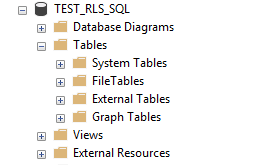

In [25]:
GRANT SELECT ON dbo.Turnover TO user_RLS_limited;
GRANT SELECT ON dbo.Turnover TO user_RLS_unlimited;

Commands completed successfully.

Total execution time: 00:00:00.003

Nun haben beide User uneingeschränkte Leserechte auf die Tabelle

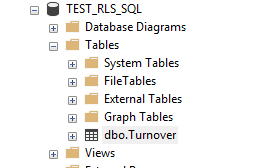

In [23]:
USE [TEST_RLS_SQL]
GO

EXEC sp_table_privileges   
   @table_name = 'Turnover'
Go  

Commands completed successfully.

(7 rows affected)

Total execution time: 00:00:00.031

TABLE_QUALIFIER,TABLE_OWNER,TABLE_NAME,GRANTOR,GRANTEE,PRIVILEGE,IS_GRANTABLE
TEST_RLS_SQL,dbo,Turnover,dbo,dbo,DELETE,YES
TEST_RLS_SQL,dbo,Turnover,dbo,dbo,INSERT,YES
TEST_RLS_SQL,dbo,Turnover,dbo,dbo,REFERENCES,YES
TEST_RLS_SQL,dbo,Turnover,dbo,dbo,SELECT,YES
TEST_RLS_SQL,dbo,Turnover,dbo,user_RLS_limited,SELECT,NO
TEST_RLS_SQL,dbo,Turnover,dbo,user_RLS_unlimited,SELECT,NO
TEST_RLS_SQL,dbo,Turnover,dbo,dbo,UPDATE,YES


# "Klassischer" Weg

Der Klassische Weg wäre es, dass man 

- eine Stored Procedure
- eine Table Valued Function 

um den Parameter @Username erweitert und danach filtert. 

In diesem Fall müsste man die Datenbank anders absichern, dass der der User selbst keine Rechte auf der Datenbank hat und die Kommunikation zwischen "Middleware" und Datenbank mittels Serviceuser passiert. Weiters muss sichergestellt werden, dass der übergebenen User nicht beeinflusst werden kann und dem tatsächlichen User des Frontends entspricht.

**<u>Ziel:</u>** Einschränkung von "user\_RLS\_limited" auf "Germany"; "user\_RLS\_unlimited" darf alles sehen.

In [10]:
DROP PROCEDURE if EXISTS dbo.usp_Turnover
GO

cREATE PROCEDURE dbo.usp_Turnover (@username as VARCHAR(50))
AS
BEGIN
	SET NOCOUNT ON;
	SELECT [ID]
      ,[Country]
      ,[Turnover] 
	  from [dbo].[Turnover]
	    WHERE ([Country] = 'Germany' and @username = 'user_RLS_limited')
	    OR (@username = 'user_RLS_unlimited');
END
GO


Commands completed successfully.

Commands completed successfully.

Total execution time: 00:00:00.009

In [11]:
EXEC dbo.usp_Turnover @username = 'user_RLS_unlimited';
EXEC dbo.usp_Turnover @username = 'user_RLS_limited';

Commands completed successfully.

Total execution time: 00:00:00.021

ID,Country,Turnover
1,China,157.8000
2,Russia,111.0000
3,Austria,1111.0000
4,Germany,9900.0000


ID,Country,Turnover
4,Germany,9900.0000


# Erweiterung um ein Filter Predicate (simple)

Nun ist es Ziel den Zugriff von user "user\_RLS\_limited" auf "Germany" einzuschräken und den zweiten User "user\_RLS\_unlimited" weiter uneingeschränkte Rechte zu gewähren.

Hierzu sind folgende Schritte notwendig:

(1) Erstellen einer Inline Table-Valued Function (Predicate Function) in der Form eines Filter Predicates

(2) Erstellen einer Security Policy

![](https://erhard-rainer.com/wp-content/uploads/2022/06/sql-server-2016-row-level-security-04.png)

## (1) Erstellen eines Filter Predicates

Die Funktion liefert 1 zurück, wenn .. erfüllt ist.

- @Country = 'Germany' & user = 'user\_RLS\_limited'
- der User 'user\_RLS\_unlimited'

In [12]:
Drop FUNCTION if EXISTS dbo.tvf_Tunover_Security1;
GO
CREATE FUNCTION dbo.tvf_Tunover_Security1(@Country as VARCHAR(50))
    RETURNS TABLE
WITH SCHEMABINDING
AS
    RETURN SELECT 1 AS tvf_Tunover_Security1_Result
    -- Logic for filter predicate
    WHERE (@Country = 'Germany' and USER_NAME() = 'user_RLS_limited')
    OR (USER_NAME() = 'user_RLS_unlimited');
GO

Commands completed successfully.

Commands completed successfully.

Total execution time: 00:00:00.010

## (2) Erstellen des Security Policy

![Parts of Row Level Security](https://sqlhints.com/wp-content/uploads/2016/01/Parts-of-Row-Level-Security.jpg)  

Quelle: https://sqlhints.com/tag/block-predicate/

In [ ]:
CREATE SECURITY POLICY TurnoverFilter1  
ADD FILTER PREDICATE dbo.tvf_Tunover_Security1([Country])
ON dbo.Turnover
WITH (STATE = ON);  
GO

In [ ]:
-- Security Policy deaktivieren
ALTER SECURITY POLICY TurnoverFilter1
WITH (STATE = OFF); 

# Erweiterung um ein Filter Predicate (Berechtigungen direkt in der Tabelle)

In der ersten Ausbaustufe ist die Logik des Filter Predicates direkt in der Funktion beheimatet. In der nächsten Ausbaustufe kommt eine Spalte User hinzu über die gesteuert wird, welcher User Zugriff auf die Zeile hat. Für den User mit uneingeschränkten Rechten muss die Logik in weiter in der Funktion sein. 

Nachteil dieser Vorgehensweise hat jedoch den Nachteil, dass nur ein Benutzer pro Zeile berechtigt werden kann.

## (0) Vorbereitung: Tabelle + Daten

In [13]:
-- Erweitern der TAbelle um eine Spalte 'Username'
ALTER TABLE dbo.Turnover
ADD username nvarchar(255);

Commands completed successfully.

Total execution time: 00:00:00.017

In [15]:
-- Befüllen der Spalte 'Username'
Update dbo.Turnover
Set username = 'user_RLS_limited'
where Country = 'Germany'

Select * from dbo.Turnover

(1 row affected)

(4 rows affected)

Total execution time: 00:00:00.013

ID,Country,Turnover,username
1,China,157.8000,NULL
2,Russia,111.0000,NULL
3,Austria,1111.0000,NULL
4,Germany,9900.0000,user_RLS_limited


## (1) Erstellen eines Filter Predicates

Die Funktion liefert 1 zurück, wenn .. erfüllt ist.

- @Country = 'Germany' & user = 'user\_RLS\_limited'
- der User 'user\_RLS\_unlimited'

In [ ]:
Drop FUNCTION if EXISTS dbo.tvf_Tunover_Security2;
GO
CREATE FUNCTION dbo.tvf_Tunover_Security2(@username as VARCHAR(50))
    RETURNS TABLE
WITH SCHEMABINDING
AS
    RETURN SELECT 1 AS tvf_Tunover_Security2_Result
    -- Logic for filter predicate
    WHERE (USER_NAME() = @username)
    OR (USER_NAME() = 'user_RLS_unlimited');
GO

## (2) Erstellen des Security Policy

In [ ]:
CREATE SECURITY POLICY TurnoverFilter2  
ADD FILTER PREDICATE dbo.tvf_Tunover_Security2([username])
ON dbo.Turnover
WITH (STATE = ON);  
GO

In [ ]:
-- Security Policy löschen
Drop SECURITY POLICY TurnoverFilter2

## Exkurs: mehrere User pro Zeile berechtigen

Es gibt für die Einschränkung, dass nur ein Benutzer pro Zeile berechtigt werden kann, eine Lösung, wenngleich ich tunlichst davon abrate.

In [ ]:
Update dbo.Turnover
Set username = null
GO

Update dbo.Turnover
Set username = 'user_RLS_limited'
where Country = 'Germany'
GO

UPDATE dbo.Turnover 
Set username = case when [username] is null then 'user_RLS_unlimited' else [username] + '|' + 'user_RLS_unlimited' end 

Select * from dbo.Turnover

In [ ]:
Drop FUNCTION if EXISTS dbo.tvf_Tunover_Security2;
GO
CREATE FUNCTION dbo.tvf_Tunover_Security2(@username as VARCHAR(50))
    RETURNS TABLE
WITH SCHEMABINDING
AS
    RETURN SELECT 1 AS tvf_Tunover_Security2_Result
    -- Logic for filter predicate
    WHERE (USER_NAME() in (Select Value from string_split(@username,'|')))
GO

In [ ]:
CREATE SECURITY POLICY TurnoverFilter2  
ADD FILTER PREDICATE dbo.tvf_Tunover_Security2([username])
ON dbo.Turnover
WITH (STATE = ON);  
GO

## Nacharbeiten: Tabelle bereinigen

In [ ]:
-- Security Policy löschen
DROP SECURITY POLICY if EXISTS [dbo].[TurnoverFilter2]
-- Function löschen
Drop FUNCTION if EXISTS dbo.tvf_Tunover_Security2;

In [ ]:
-- Spalte wieder löschen
ALTER TABLE dbo.Turnover
Drop COLUMN username;

# Erweiterung um ein Filter Predicate (mit Config-Tabelle)

Da die zuletzt beschreibene Methode mit mehrerne Usern in einem Feld nicht empfehlenswert hinsichtlich Performance ist,  braucht man eine schneller Methode. 

1. Hierzu legen wir eine zusätzliche Tabelle an \[dbo\].\[Permissions\]
2. danach erstellen wir ein Filter Predicate 
3. und eine Security Policy

## Vorbereitung: Setzen der Berechtigungen

Über eine weitere Tabelle \[dbo\].\[Permissions\] sollen die Rechte gesteuert werden. Grundsätzlich soll der user "user\_RLS\_limited" nur Germany sehen dürfen und der User User 'user\_RLS\_unlimited' soll alles sehen dürfen. Die Rechte von user\_RLS\_unlimited soll aber nicht über die Tabelle sondern über den Filter Predicate gesteuert werden.

In [16]:
DROP TAble if EXISTS [dbo].[Permisisons]
GO

CREATE TABLE [dbo].[Permisisons](
    [Country] [varchar](50) not NULL,
    [Username] [varchar](50) not null
)

Commands completed successfully.

Commands completed successfully.

Total execution time: 00:00:00.029

In [26]:
Truncate Table [dbo].[Permisisons]
GO
Insert into [dbo].[Permisisons](Country,Username)
Values ('Germany','user_RLS_limited')

Commands completed successfully.

(1 row affected)

Total execution time: 00:00:00.031

## (1) Erstellen eines Filter Predicates

Die Funktion liefert 1 zurück, wenn .. erfüllt ist.

- @Country = 'Germany' & user = 'user\_RLS\_limited'
- der User 'user\_RLS\_unlimited'

In [28]:
-- Möglichkeit 1
Drop FUNCTION if EXISTS dbo.tvf_Tunover_Security3;
GO
CREATE FUNCTION dbo.tvf_Tunover_Security3(@Country as VARCHAR(50))
    RETURNS TABLE
WITH SCHEMABINDING
AS
    RETURN SELECT 1 AS tvf_Tunover_Security3_Result
    -- Logic for filter predicate
    WHERE (@Country in (Select [Country] from [dbo].[Permisisons] where [Username] = USER_NAME()))
    OR (USER_NAME() = 'user_RLS_unlimited');
GO

Commands completed successfully.

Commands completed successfully.

Total execution time: 00:00:00.017

In [29]:
-- Möglichkeit 2 -- funktioniert 
Drop SECURITY POLICY if exists TurnoverFilter3
GO
Drop FUNCTION if EXISTS dbo.tvf_Tunover_Security3;
GO
CREATE FUNCTION dbo.tvf_Tunover_Security3(@Country as VARCHAR(50))
    RETURNS TABLE
WITH SCHEMABINDING
AS
    RETURN (SELECT 1 AS tvf_Tunover_Security3_Result
    from dbo.Turnover as t
    inner join dbo.Permisisons as p 
    on t.Country = p.Country 
    Where p.Username = USER_NAME()
    and t.Country = @Country);
GO

Commands completed successfully.

Commands completed successfully.

Commands completed successfully.

Total execution time: 00:00:00.016

## (2) Erstellen des Security Policy

In [30]:
Drop SECURITY POLICY if exists TurnoverFilter1
Drop SECURITY POLICY if exists TurnoverFilter3
GO
CREATE SECURITY POLICY TurnoverFilter3
ADD FILTER PREDICATE dbo.tvf_Tunover_Security3([Country])
ON dbo.Turnover
WITH (STATE = ON);  
GO

Commands completed successfully.

Commands completed successfully.

Total execution time: 00:00:00.016

# Limitieren der Schreibrechte

BLOCK Predicates funktionieren ähnlich den FILTER PREDICATES, was dazu führt, dass man bereits entwickelte FILTER PREDICATES wiederverwenden kann.

Beispiel ohen konkrete Einschränkung auf eine Operation

```
CREATE SECURITY POLICY Security.userAccessPolicy
 ADD FILTER PREDICATE Security.userAccessPredicate(UserId) ON dbo.MyTable,
 ADD BLOCK PREDICATE Security.userAccessPredicate(UserId) ON dbo.MyTable
```

Wenn keine Operation festgelegt wird, wirkt sich auf jeder Operation aus. Man kann aber auch den Block Predicate auf einzelne Operationen einschränken:

- AFTER INSERT and AFTER UPDATE - prüft gegen die neue Zeile
- BEFORE UPDATE and BEFORE DELETE - prüft gegen die alte Zeile

```
CREATE SECURITY POLICY Security.tenantPolicy
 ADD FILTER PREDICATE Security.tenantAccessPredicate(TenantId) ON dbo.Sales,
 ADD BLOCK PREDICATE Security.tenantAccessPredicate(TenantId) ON dbo.Sales AFTER INSERT
go
```

Anmerkung:  

- Wird ein Filter-predicate verwendet, benötigt man keine BEFORE UPDATE oder BEFORE DELETE Block Predicate. 
- Hat man eine Spalten Permission, benötigt man auch keinen AFTER UPDATE

## INSERT, UPDATE , DELTE

In [ ]:
DROP SECURITY POLICY IF EXISTS [dbo].[TurnoverFilter1]
DROP SECURITY POLICY IF EXISTS [dbo].[TurnoverFilter2]
DROP SECURITY POLICY IF EXISTS [dbo].[TurnoverFilter3]
DROP SECURITY POLICY IF EXISTS [dbo].[TurnoverFilter5]

Drop Function if exists [dbo].[tvf_Tunover_Security1]
Drop Function if exists [dbo].[tvf_Tunover_Security2]
Drop Function if exists [dbo].[tvf_Tunover_Security3]
Drop Function if exists [dbo].[tvf_Tunover_Security5]


CREATE FUNCTION [dbo].[tvf_Tunover_Security5](@Country as VARCHAR(50))
    RETURNS TABLE
WITH SCHEMABINDING
AS
    RETURN SELECT 1 AS tvf_Tunover_Security5_Result
    -- Logic for filter predicate
    WHERE (@Country in (Select [Country] from [dbo].[Permisisons] where [Username] = USER_NAME()))
    OR (USER_NAME() = 'user_RLS_unlimited');
GO

CREATE SECURITY POLICY [dbo].[TurnoverFilter5]
 ADD FILTER PREDICATE [dbo].[tvf_Tunover_Security5]([Country]) ON [dbo].[Turnover],
 ADD BLOCK PREDICATE [dbo].[tvf_Tunover_Security5]([Country]) ON [dbo].[Turnover] 
go


In [ ]:
GRANT INSERT ON dbo.Turnover TO user_RLS_limited;
GRANT DELETE ON dbo.Turnover TO user_RLS_limited;
GRANT UPDATE ON dbo.Turnover TO user_RLS_limited;

## UPDATE, DELETE

In [ ]:
-- auszuführen mit einem User mit eingeschränkten Rechten
-- FILTER PREDICATE => nur Germany
Select * from [dbo].[Turnover]
-- nicht zulässig, da 'Austria'
INSERT INTO [dbo].[Turnover]([Country],[Turnover])
Values ('Austria','1558')

-- zulässig, da 'Germany'
INSERT INTO [dbo].[Turnover]([Country],[Turnover])
Values ('Germany','1558')

-- Ausgabe
Select * from [dbo].[Turnover]

-- zulässig, aber 0 rows affected, da die anderen nicht sichbar für den User sind
Delete [dbo].[Turnover]
Where Country = 'Austria'

-- zulässig
Delete [dbo].[Turnover]
Where Turnover = 1558.0000
and Country = 'Germany'

-- nichts passiert, da dieser Datensatz nicht für user sichtbar
Update [dbo].[Turnover]
Set Turnover = 100000
where ID = 3
-- ok, da es sich um einen Germany DS handelt
Update [dbo].[Turnover]
Set Turnover = 500
where ID = 4


In [ ]:
DROP SECURITY POLICY IF EXISTS [dbo].[TurnoverFilter1]
DROP SECURITY POLICY IF EXISTS [dbo].[TurnoverFilter2]
DROP SECURITY POLICY IF EXISTS [dbo].[TurnoverFilter3]
DROP SECURITY POLICY IF EXISTS [dbo].[TurnoverFilter5]

Drop Function if exists [dbo].[tvf_Tunover_Security1]
Drop Function if exists [dbo].[tvf_Tunover_Security2]
Drop Function if exists [dbo].[tvf_Tunover_Security3]
Drop Function if exists [dbo].[tvf_Tunover_Security5]


CREATE FUNCTION [dbo].[tvf_Tunover_Security5](@Country as VARCHAR(50))
    RETURNS TABLE
WITH SCHEMABINDING
AS
    RETURN SELECT 1 AS tvf_Tunover_Security5_Result
    -- Logic for filter predicate
    WHERE (@Country in (Select [Country] from [dbo].[Permisisons] where [Username] = USER_NAME()))
    OR (USER_NAME() = 'user_RLS_unlimited');
GO

CREATE SECURITY POLICY [dbo].[TurnoverFilter5]
 ADD FILTER PREDICATE [dbo].[tvf_Tunover_Security5]([Country]) ON [dbo].[Turnover],
 ADD BLOCK PREDICATE [dbo].[tvf_Tunover_Security5]([Country]) ON [dbo].[Turnover] Before Update,
 ADD BLOCK PREDICATE [dbo].[tvf_Tunover_Security5]([Country]) ON [dbo].[Turnover] Before Delete
go

In [ ]:

GRANT INSERT ON dbo.Turnover TO user_RLS_limited;
GRANT DELETE ON dbo.Turnover TO user_RLS_limited;
GRANT UPDATE ON dbo.Turnover TO user_RLS_limited;

In [ ]:
-- auszuführen mit einem User mit eingeschränkten Rechten
-- FILTER PREDICATE => nur Germany
Select * from [dbo].[Turnover]
-- zulässig, da kein AFTER IMPORT
INSERT INTO [dbo].[Turnover]([Country],[Turnover])
Values ('Austria','1558')

-- zulässig, da 'Germany'
INSERT INTO [dbo].[Turnover]([Country],[Turnover])
Values ('Germany','1558')

-- Ausgabe
Select * from [dbo].[Turnover]

-- zulässig, aber 0 rows affected, da die anderen nicht sichbar für den User sind
Delete [dbo].[Turnover]
Where Country = 'Austria'

-- zulässig
Delete [dbo].[Turnover]
Where Turnover = 1558.0000
and Country = 'Germany'

-- nichts passiert, da dieser Datensatz nicht für user sichtbar
Update [dbo].[Turnover]
Set Turnover = 100000
where ID = 3
-- ok, da es sich um einen Germany DS handelt
Update [dbo].[Turnover]
Set Turnover = 500
where ID = 4

# Datenbank löschen

In [ ]:
use master 
go
alter database [TEST_RLS_SQL]
set single_user with rollback immediate
GO
Drop DATABASE if exists [TEST_RLS_SQL]
GO